# Test influence of fracture complexity on conditioning
This test focuses on the complexity that inclusion of fractures bring. In particular, we will start from a basic model with 0 fractures, find the optimal scaling parameters, then successively add fractures and investigate changes in the optimal conditioning.

### possible bias
* `mesh_args` will have different impact on un-fractured to fractured domains.
* Inclusion of intersecting fractures may change the results.

## Code

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.extend([
    '/home/haakon/mastersproject', 
    '/home/haakon/mastersproject/src/mastersproject'
])

import porepy as pp
import numpy as np
import pandas as pd

# import GTS as gts
from GTS.test.test_scaling.test_scaling_util import test_conditioning

# Logging:
import logging
logging.basicConfig(level='INFO')

/home/haakon/porepy/src/porepy/viz/exporter.py:928: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  angle = np.arccos(np.dot(normals[:, fi], reference))


# General setup:
For all test cases, we will use the following common parameters:
* `sz = 20`\
    This sets `mesh_size_frac`, `mesh_size_min`, `mesh_size_bound` to `sz`\
    The "hope" is that uniform mesh size introduce the least amount of bias between tests of varying number of fractures.
* scaling coefficients:
    * We have previously optimal scaling tests for 0 fractures and 5 fractures. Then, the optimal coefficients were `ls=0.05, ss=1e9` (condition: `~1e4`) and `ls=0.01, ss=1e10` (conditioning: `~1e9`), respectively.
    * SETUP RANGES: 
        * `ls = [0.1, 0.08, 0.05, 0.03, 0.01, 0.005]`
        * `ss = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10]`
        
        
### Results from initial testing
* **12.04.2020**:
    * With length scales [0.1, 0.005] and scalar scales [1e8, 5e10], we observed varying condition number minima for increasing number of fractures. In particular, some minima were observed near the "edge" of the data. We re-do the experiment with larger ranges to cover edge-cases for any number of fractures.
    
#### Adding more scales:
* length scale:
    * higher numbers: i.e. `0.3, 0.5, 0.8, 1`
* scalar scale
    * lower numbers: i.e. `1e6, 5e6, 1e7, 5e8`
    * higher numbers: i.e. `1e11, 5e11, 1e12`

In [2]:
sz = 20
length_scales = [1, 0.8, 0.5, 0.3, 0.1, 0.08, 0.05, 0.03, 0.01, 0.005]
scalar_scales = [1e6, 5e6, 1e7, 5e8, 1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12]

In [3]:
def aggregate_results_over_fractures(**kwargs):
    """ Run 'test_conditioning' for increasing number of fractures
    
    Pass list of 'length_scale' and 'scalar_scale'
    also 'sz', which is the uniform mesh size.
    """
    
    all_shearzones = ["S1_1", "S1_2", "S1_3", "S3_1", "S3_2"]
    
    results = pd.DataFrame()  # Initialize empty dataframe
    
    for i in range(len(all_shearzones) + 1):
        _sz = all_shearzones[:i]
        shearzone_names = _sz if _sz else None  # Convert empty list to None
        
        _it_result = test_conditioning(
            **kwargs,
            shearzone_names=shearzone_names,
        )
        
        # set the shearzones as column.
        if shearzone_names:
            _it_result['shearzone_names'] = [set(shearzone_names)] *_it_result.shape[0]
        else:
            _it_result['shearzone_names'] = None
        
        results = results.append(_it_result, ignore_index=True)
        
    
    # count number of fractures for each data point
    results['n_sz'] = results['shearzone_names'].apply(lambda x: len(x) if x else 0)
        
    return results

# New approach: Iterate from no fracs to all fracs


TODO:
* Re-use the same grid for efficiency

In [4]:
full = aggregate_results_over_fractures(
    length_scales=length_scales, 
    scalar_scales=scalar_scales, 
    sz=sz,
)

INFO:GTS.isc_modelling.setup:Preparing setup for simulation on 2020-04-12T15:27:40+02:00
INFO:GTS.isc_modelling.setup:Simulation parameters:
 {'_gravity_bc': False,
 '_gravity_bc_p': False,
 '_gravity_src': False,
 'bounding_box': {'xmax': 80,
                  'xmin': -20,
                  'ymax': 150,
                  'ymin': 50,
                  'zmax': 75,
                  'zmin': -25},
 'folder_name': PosixPath('/home/haakon/mastersproject/src/mastersproject/GTS/isc_modelling/results/test_fracture_complexity/test_1'),
 'length_scale': 1,
 'mesh_args': {'mesh_size_bound': 20,
               'mesh_size_frac': 20,
               'mesh_size_min': 20},
 'path_head': 'test_fracture_complexity/test_1',
 'scalar_scale': 1000000.0,
 'shearzone_names': None,
 'solver': 'direct',
 'source_scalar_borehole_shearzone': {'borehole': 'INJ1', 'shearzone': 'S1_2'},
 'stress': array([[-11393046.22034133,    597621.26708787,   1842573.57669909],
       [   597621.26708787,  -8873267.78285116,   -

ls= 1.000e+00, ss= 1.000e+06
Max element in A 1.76e+06
Max 6.01e+06 and min 6.21e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01335
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00068
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01162
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+06
Max element in A 3.51e+05
Max 1.20e+06 and min 6.21e+01 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa72ebd6f60>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01297
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00167
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e+00, ss= 1.000e+07
Max element in A 1.76e+05
Max 6.01e+05 and min 6.22e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01679
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01637
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+08
Max element in A 3.51e+03
Max 1.22e+04 and min 7.01e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01722
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00073
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01385
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 1.000e+08
Max element in A 1.76e+04
Max 6.03e+04 and min 6.37e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01380
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01086
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+08
Max element in A 3.51e+03
Max 1.22e+04 and min 7.01e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01294
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00061
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01161
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 1.000e+09
Max element in A 1.76e+03
Max 6.20e+03 and min 7.80e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01424
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00079
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01130
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+09
Max element in A 4.28e+02
Max 1.59e+03 and min 1.39e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01341
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00088
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01373
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 1.000e+10
Max element in A 8.55e+02
Max 2.29e+03 and min 1.71e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01309
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00069
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01390
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+10
Max element in A 4.28e+03
Max 7.92e+03 and min 5.35e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01259
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01081
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 1.000e+11
Max element in A 8.55e+03
Max 1.50e+04 and min 3.79e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01394
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01336
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 5.000e+11
Max element in A 4.28e+04
Max 7.13e+04 and min 2.54e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01426
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00073
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01468
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e+00, ss= 1.000e+12
Max element in A 8.55e+04
Max 1.42e+05 and min 2.39e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01477
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00072
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01280
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+06
Max element in A 2.22e+06
Max 8.30e+06 and min 9.87e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01357
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00106
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01162
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 5.000e+06
Max element in A 4.44e+05
Max 1.66e+06 and min 9.88e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01432
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00077
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01262
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+07
Max element in A 2.22e+05
Max 8.30e+05 and min 9.90e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01388
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00067
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01375
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 5.000e+08
Max element in A 4.44e+03
Max 1.69e+04 and min 1.14e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01265
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00136
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01105
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+08
Max element in A 2.22e+04
Max 8.33e+04 and min 1.02e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01263
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00134
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01458
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 5.000e+08
Max element in A 4.44e+03
Max 1.69e+04 and min 1.14e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01539
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01410
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+09
Max element in A 2.22e+03
Max 8.60e+03 and min 1.29e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01326
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01180
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 5.000e+09
Max element in A 8.24e+02
Max 2.68e+03 and min 2.46e+02 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e1c16d8>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01452
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 8.000e-01, ss= 1.000e+10
Max element in A 1.65e+03
Max 4.04e+03 and min 2.25e+02 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa721518940>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01302
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniqu

ls= 8.000e-01, ss= 5.000e+10
Max element in A 8.24e+03
Max 1.49e+04 and min 7.36e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01233
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01036
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+11
Max element in A 1.65e+04
Max 2.85e+04 and min 5.43e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01334
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00048
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01136
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 5.000e+11
Max element in A 8.24e+04
Max 1.37e+05 and min 3.89e+01 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01526
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01114
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-01, ss= 1.000e+12
Max element in A 1.65e+05
Max 2.74e+05 and min 3.69e+01 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e48ec18>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01438
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-01, ss= 1.000e+06
Max element in A 3.51e+06
Max 1.20e+07 and min 2.48e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01260
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01231
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+06
Max element in A 7.03e+05
Max 2.40e+06 and min 2.49e+02 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71eb82a58>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01326
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00119
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-01, ss= 1.000e+07
Max element in A 3.51e+05
Max 1.20e+06 and min 2.50e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01351
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01016
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+08
Max element in A 7.03e+03
Max 2.48e+04 and min 3.12e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01388
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00075
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01233
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 1.000e+08
Max element in A 3.51e+04
Max 1.21e+05 and min 2.61e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01413
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00102
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01319
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+08
Max element in A 7.03e+03
Max 2.48e+04 and min 3.12e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01391
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01380
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 1.000e+09
Max element in A 3.51e+03
Max 1.28e+04 and min 3.75e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01299
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00109
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01116
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+09
Max element in A 3.42e+03
Max 9.16e+03 and min 6.83e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01588
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00080
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01905
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 1.000e+10
Max element in A 6.84e+03
Max 1.48e+04 and min 4.01e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01297
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00198
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01111
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+10
Max element in A 3.42e+04
Max 5.98e+04 and min 1.52e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01228
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01167
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 1.000e+11
Max element in A 6.84e+04
Max 1.16e+05 and min 1.20e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01264
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01097
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-01, ss= 5.000e+11
Max element in A 3.42e+05
Max 5.67e+05 and min 9.54e+01 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71f0db5c0>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01774
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniqu

ls= 5.000e-01, ss= 1.000e+12
Max element in A 6.84e+05
Max 1.13e+06 and min 9.23e+01 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa721518940>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01437
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00050
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 3.000e-01, ss= 1.000e+06
Max element in A 6.50e+06
Max 2.24e+07 and min 6.89e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01740
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01498
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 5.000e+06
Max element in A 1.30e+06
Max 4.48e+06 and min 6.92e+02 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e536400>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01609
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00104
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 3.000e-01, ss= 1.000e+07
Max element in A 6.50e+05
Max 2.24e+06 and min 6.94e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01270
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01081
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.30e+04
Max 4.68e+04 and min 9.76e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01257
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00049
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01114
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 1.000e+08
Max element in A 6.50e+04
Max 2.26e+05 and min 7.46e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01309
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00156
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01113
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.30e+04
Max 4.68e+04 and min 9.76e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01420
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01688
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 1.000e+09
Max element in A 6.50e+03
Max 2.44e+04 and min 1.26e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01405
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01186
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 5.000e+09
Max element in A 1.56e+04
Max 3.49e+04 and min 1.30e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01268
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01655
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 1.000e+10
Max element in A 3.12e+04
Max 6.08e+04 and min 7.74e+02 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71df64c18>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01422
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 3.000e-01, ss= 5.000e+10
Max element in A 1.56e+05
Max 2.67e+05 and min 3.55e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01749
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01707
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 1.000e+11
Max element in A 3.12e+05
Max 5.26e+05 and min 3.03e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01364
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00073
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01097
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-01, ss= 5.000e+11
Max element in A 1.56e+06
Max 2.59e+06 and min 2.61e+02 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71eb7ee48>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01450
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 3.000e-01, ss= 1.000e+12
Max element in A 3.12e+06
Max 5.17e+06 and min 2.56e+02 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01259
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01116
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 1.000e+06
Max element in A 1.78e+07
Max 6.64e+07 and min 6.33e+03 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e3aa278>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01156
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00081
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-01, ss= 5.000e+06
Max element in A 3.56e+06
Max 1.33e+07 and min 6.39e+03 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa72176dfd0>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01398
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-01, ss= 1.000e+07
Max element in A 1.78e+06
Max 6.66e+06 and min 6.47e+03 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa72168ecf8>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01320
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.22e+04
Max 1.54e+05 and min 1.39e+04 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71dee1630>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01462
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00084
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniqu

ls= 1.000e-01, ss= 1.000e+08
Max element in A 1.78e+05
Max 6.83e+05 and min 7.89e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01238
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00048
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01140
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.22e+04
Max 1.54e+05 and min 1.39e+04 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71dd1db70>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01442
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00110
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-01, ss= 1.000e+09
Max element in A 8.44e+04
Max 2.24e+05 and min 1.71e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01366
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00070
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01234
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 5.000e+09
Max element in A 4.22e+05
Max 7.81e+05 and min 5.33e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01271
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00046
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01062
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 1.000e+10
Max element in A 8.44e+05
Max 1.48e+06 and min 3.78e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01246
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00110
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01201
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 5.000e+10
Max element in A 4.22e+06
Max 7.05e+06 and min 2.55e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00050
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01114
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 1.000e+11
Max element in A 8.44e+06
Max 1.40e+07 and min 2.39e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01345
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00098
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01076
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 5.000e+11
Max element in A 4.22e+07
Max 6.98e+07 and min 2.27e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01415
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00068
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01281
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-01, ss= 1.000e+12
Max element in A 8.44e+07
Max 1.39e+08 and min 2.26e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01307
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00059
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01072
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+06
Max element in A 2.36e+07
Max 8.89e+07 and min 9.64e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01287
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00047
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01094
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+06
Max element in A 4.73e+06
Max 1.78e+07 and min 9.76e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01196
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00163
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00927
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+07
Max element in A 2.36e+06
Max 8.92e+06 and min 9.91e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01089
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00111
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01099
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+08
Max element in A 7.25e+04
Max 2.43e+05 and min 2.47e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01219
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.01738
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00985
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+08
Max element in A 2.36e+05
Max 9.29e+05 and min 1.26e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01222
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00979
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+08
Max element in A 7.25e+04
Max 2.43e+05 and min 2.47e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01880
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01427
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+09
Max element in A 1.45e+05
Max 3.64e+05 and min 2.25e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01261
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00091
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00945
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+09
Max element in A 7.25e+05
Max 1.33e+06 and min 7.45e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01384
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00201
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01159
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+10
Max element in A 1.45e+06
Max 2.53e+06 and min 5.51e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01367
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00066
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01099
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+10
Max element in A 7.25e+06
Max 1.21e+07 and min 3.95e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01581
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00152
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01455
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+11
Max element in A 1.45e+07
Max 2.42e+07 and min 3.76e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01251
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00157
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.02177
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 5.000e+11
Max element in A 7.25e+07
Max 1.20e+08 and min 3.60e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01338
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00117
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01331
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 8.000e-02, ss= 1.000e+12
Max element in A 1.45e+08
Max 2.41e+08 and min 3.58e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01638
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01080
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+06
Max element in A 3.56e+07
Max 1.33e+08 and min 2.54e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01407
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01107
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 5.000e+06
Max element in A 7.11e+06
Max 2.66e+07 and min 2.59e+04 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa72161b898>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01527
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniqu

ls= 5.000e-02, ss= 1.000e+07
Max element in A 3.56e+06
Max 1.34e+07 and min 2.65e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01509
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00067
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01350
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 5.000e+08
Max element in A 3.37e+05
Max 8.95e+05 and min 6.84e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01291
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00105
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01126
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+08
Max element in A 3.56e+05
Max 1.41e+06 and min 3.77e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01349
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00132
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01389
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 5.000e+08
Max element in A 3.37e+05
Max 8.95e+05 and min 6.84e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01411
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01332
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+09
Max element in A 6.75e+05
Max 1.45e+06 and min 3.99e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01436
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00137
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01095
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 5.000e+09
Max element in A 3.37e+06
Max 5.91e+06 and min 1.51e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01592
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00048
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01224
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+10
Max element in A 6.75e+06
Max 1.15e+07 and min 1.20e+04 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71c24fb38>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01455
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00061
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-02, ss= 5.000e+10
Max element in A 3.37e+07
Max 5.61e+07 and min 9.58e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01377
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00067
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01394
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+11
Max element in A 6.75e+07
Max 1.12e+08 and min 9.27e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01253
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00152
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01122
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 5.000e+11
Max element in A 3.37e+08
Max 5.58e+08 and min 9.02e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01421
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00121
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01315
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-02, ss= 1.000e+12
Max element in A 6.75e+08
Max 1.12e+09 and min 8.99e+03 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01285
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00069
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01314
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+06
Max element in A 5.69e+07
Max 1.91e+08 and min 6.99e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01422
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00031
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01351
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+06
Max element in A 1.14e+07
Max 3.84e+07 and min 7.22e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01210
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00092
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00950
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+07
Max element in A 5.69e+06
Max 1.93e+07 and min 7.51e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01282
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00049
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01251
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.17e+06
Max 2.88e+06 and min 1.29e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01211
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00121
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01130
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+08
Max element in A 5.69e+05
Max 2.14e+06 and min 1.27e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02062
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00191
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01257
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.17e+06
Max 2.88e+06 and min 1.29e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01497
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00116
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01305
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+09
Max element in A 2.33e+06
Max 4.93e+06 and min 7.69e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01242
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00079
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01019
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+09
Max element in A 1.17e+07
Max 2.13e+07 and min 3.50e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01283
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00199
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01203
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+10
Max element in A 2.33e+07
Max 4.18e+07 and min 2.97e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01616
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00083
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01426
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+10
Max element in A 1.17e+08
Max 2.06e+08 and min 2.55e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01117
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00101
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01109
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+11
Max element in A 2.33e+08
Max 4.10e+08 and min 2.50e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01305
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00182
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01061
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.17e+09
Max 2.05e+09 and min 2.46e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01467
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00125
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01207
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.33e+09
Max 4.10e+09 and min 2.45e+04 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01397
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00086
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01427
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 1.000e+06
Max element in A 1.89e+08
Max 7.13e+08 and min 6.30e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01139
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00072
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01193
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+06
Max element in A 3.78e+07
Max 1.45e+08 and min 6.92e+05 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e230cc0>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01440
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00084
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-02, ss= 1.000e+07
Max element in A 1.89e+07
Max 7.36e+07 and min 7.70e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01322
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00048
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01515
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.71e+07
Max 6.94e+07 and min 5.39e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01440
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00075
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01206
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 1.000e+08
Max element in A 7.42e+06
Max 2.02e+07 and min 1.72e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01483
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01156
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.71e+07
Max 6.94e+07 and min 5.39e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01457
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00114
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01297
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 1.000e+09
Max element in A 7.42e+07
Max 1.31e+08 and min 3.84e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01087
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00133
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.02461
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+09
Max element in A 3.71e+08
Max 6.24e+08 and min 2.59e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01272
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00047
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00994
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 1.000e+10
Max element in A 7.42e+08
Max 1.24e+09 and min 2.44e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01494
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00046
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01003
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+10
Max element in A 3.71e+09
Max 6.16e+09 and min 2.31e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01387
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00185
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01101
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 1.000e+11
Max element in A 7.42e+09
Max 1.23e+10 and min 2.30e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01503
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00075
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01266
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 1.000e-02, ss= 5.000e+11
Max element in A 3.71e+10
Max 6.16e+10 and min 2.28e+05 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71da83828>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01347
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 1.000e-02, ss= 1.000e+12
Max element in A 7.42e+10
Max 1.23e+11 and min 2.28e+05 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71bda7630>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01461
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-03, ss= 1.000e+06
Max element in A 3.78e+08
Max 1.43e+09 and min 2.58e+06 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71ea99978>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01530
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00085
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-03, ss= 5.000e+06
Max element in A 7.56e+07
Max 2.95e+08 and min 3.08e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01374
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00086
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01390
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+07
Max element in A 3.78e+07
Max 1.52e+08 and min 3.70e+06 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71c77d208>)
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01347
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.97e+08
Max 5.24e+08 and min 1.53e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01621
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00050
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01030
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+08
Max element in A 5.94e+07
Max 1.30e+08 and min 4.02e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01387
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01120
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.97e+08
Max 5.24e+08 and min 1.53e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01406
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01219
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+09
Max element in A 5.94e+08
Max 1.02e+09 and min 1.22e+06 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01330
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01372
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 5.000e+09
Max element in A 2.97e+09
Max 4.96e+09 and min 9.74e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01394
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00082
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01183
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+10
Max element in A 5.94e+09
Max 9.88e+09 and min 9.43e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01604
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00098
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01186
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 5.000e+10
Max element in A 2.97e+10
Max 4.93e+10 and min 9.18e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01418
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01121
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+11
Max element in A 5.94e+10
Max 9.85e+10 and min 9.15e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01315
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00161
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.01192
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 5.000e+11
Max element in A 2.97e+11
Max 4.93e+11 and min 9.13e+05 A sum.


/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01290
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00247
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 48 points, 36
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 8 points, 12 edges. Ellapsed time
                    0.00991
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.frac

ls= 5.000e-03, ss= 1.000e+12
Max element in A 5.94e+11
Max 9.85e+11 and min 9.12e+05 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01515
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00088
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+06
Max element in A 2.98e+11
Max 3.04e+11 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01574
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00130
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 5.000e+06
Max element in A 5.96e+10
Max 6.08e+10 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01377
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00071
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+07
Max element in A 2.98e+10
Max 3.04e+10 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71b5cefd0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01297
INFO:porepy.fracs.fract

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.96e+08
Max 6.08e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01400
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00082
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+08
Max element in A 2.98e+09
Max 3.04e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01311
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00116
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.96e+08
Max 6.08e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01614
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00069
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+09
Max element in A 2.98e+08
Max 3.04e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02250
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00115
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 5.000e+09
Max element in A 5.96e+07
Max 6.08e+07 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01413
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00080
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+10
Max element in A 2.98e+07
Max 3.04e+07 and min 2.98e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01264
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 5.000e+10
Max element in A 5.96e+06
Max 6.08e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01209
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00030
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+11
Max element in A 2.98e+06
Max 3.04e+06 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa721437128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02016
INFO:porepy.fracs.fract

ls= 1.000e+00, ss= 5.000e+11
Max element in A 5.96e+05
Max 6.08e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01355
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e+00, ss= 1.000e+12
Max element in A 2.98e+05
Max 3.04e+05 and min 2.82e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01346
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00070
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+06
Max element in A 1.40e+11
Max 1.48e+11 and min 2.83e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715a18048>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01626
INFO:porepy.fracs.fract

ls= 8.000e-01, ss= 5.000e+06
Max element in A 2.79e+10
Max 2.96e+10 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01353
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+07
Max element in A 1.40e+10
Max 1.48e+10 and min 2.92e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01322
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00072
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.79e+08
Max 2.96e+08 and min 2.97e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01519
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00128
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+08
Max element in A 1.40e+09
Max 1.48e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01424
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00130
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.79e+08
Max 2.96e+08 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00036
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+09
Max element in A 1.40e+08
Max 1.48e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01600
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00133
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 5.000e+09
Max element in A 2.79e+07
Max 2.96e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01431
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00149
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+10
Max element in A 1.40e+07
Max 1.48e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00133
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 5.000e+10
Max element in A 2.79e+06
Max 2.96e+06 and min 2.47e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a2261d0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01376
INFO:porepy.fracs.fract

ls= 8.000e-01, ss= 1.000e+11
Max element in A 1.40e+06
Max 1.48e+06 and min 2.50e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01659
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 5.000e+11
Max element in A 2.79e+05
Max 2.96e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01583
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00105
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-01, ss= 1.000e+12
Max element in A 1.60e+05
Max 2.65e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01572
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+06
Max element in A 3.72e+10
Max 3.80e+10 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01515
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00188
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 5.000e+06
Max element in A 7.45e+09
Max 7.59e+09 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01540
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+07
Max element in A 3.72e+09
Max 3.80e+09 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01552
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00070
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 5.000e+08
Max element in A 7.45e+07
Max 7.59e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01226
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00099
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+08
Max element in A 3.72e+08
Max 3.80e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a49ddd8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01375
INFO:porepy.fracs.fract

ls= 5.000e-01, ss= 5.000e+08
Max element in A 7.45e+07
Max 7.59e+07 and min 2.68e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01237
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00076
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+09
Max element in A 3.72e+07
Max 3.80e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01410
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00178
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 5.000e+09
Max element in A 7.45e+06
Max 7.59e+06 and min 2.86e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01689
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00110
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+10
Max element in A 3.72e+06
Max 3.80e+06 and min 2.77e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a3fb710>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01355
INFO:porepy.fracs.fract

ls= 5.000e-01, ss= 5.000e+10
Max element in A 7.45e+05
Max 7.59e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+11
Max element in A 3.72e+05
Max 3.80e+05 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01261
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00142
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 5.000e+11
Max element in A 2.82e+05
Max 4.97e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01273
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00127
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-01, ss= 1.000e+12
Max element in A 5.64e+05
Max 9.90e+05 and min 2.80e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01536
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+06
Max element in A 7.31e+09
Max 7.75e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01284
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00103
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 5.000e+06
Max element in A 1.46e+09
Max 1.55e+09 and min 2.72e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01447
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+07
Max element in A 7.31e+08
Max 7.75e+08 and min 2.58e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01347
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.46e+07
Max 1.55e+07 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01468
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00066
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+08
Max element in A 7.31e+07
Max 7.75e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01400
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.46e+07
Max 1.55e+07 and min 2.91e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01396
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00145
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+09
Max element in A 7.31e+06
Max 7.75e+06 and min 2.78e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71e3e81d0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01304
INFO:porepy.fracs.fract

ls= 3.000e-01, ss= 5.000e+09
Max element in A 1.46e+06
Max 1.55e+06 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01456
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00152
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+10
Max element in A 7.31e+05
Max 7.75e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01340
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 5.000e+10
Max element in A 1.47e+05
Max 2.52e+05 and min 2.40e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01282
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+11
Max element in A 2.94e+05
Max 4.95e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01237
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 5.000e+11
Max element in A 1.47e+06
Max 2.44e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01407
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-01, ss= 1.000e+12
Max element in A 2.94e+06
Max 4.87e+06 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01512
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00077
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 1.000e+06
Max element in A 2.73e+08
Max 2.89e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01352
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+06
Max element in A 5.45e+07
Max 5.78e+07 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01433
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00116
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 1.000e+07
Max element in A 2.73e+07
Max 2.89e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01488
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00056
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+08
Max element in A 5.45e+05
Max 5.78e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01564
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 1.000e+08
Max element in A 2.73e+06
Max 2.89e+06 and min 2.59e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00091
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+08
Max element in A 5.45e+05
Max 5.78e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71ab44d68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01589
INFO:porepy.fracs.fract

ls= 1.000e-01, ss= 1.000e+09
Max element in A 2.73e+05
Max 2.89e+05 and min 2.39e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01428
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+09
Max element in A 4.09e+05
Max 7.56e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71cffab70>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01434
INFO:porepy.fracs.fract

ls= 1.000e-01, ss= 1.000e+10
Max element in A 8.17e+05
Max 1.43e+06 and min 2.95e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01525
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00070
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+10
Max element in A 4.09e+06
Max 6.84e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.03072
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00122
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 1.000e+11
Max element in A 8.17e+06
Max 1.36e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01465
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 5.000e+11
Max element in A 4.09e+07
Max 6.76e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01377
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00128
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-01, ss= 1.000e+12
Max element in A 8.17e+07
Max 1.35e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01380
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00113
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+06
Max element in A 1.60e+08
Max 1.67e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01428
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00147
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+06
Max element in A 3.20e+07
Max 3.35e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01412
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00138
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+07
Max element in A 1.60e+07
Max 1.67e+07 and min 2.95e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01283
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+08
Max element in A 3.20e+05
Max 3.35e+05 and min 2.35e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01575
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00128
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+08
Max element in A 1.60e+06
Max 1.67e+06 and min 2.48e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01220
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00030
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+08
Max element in A 3.20e+05
Max 3.35e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01346
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+09
Max element in A 1.60e+05
Max 3.85e+05 and min 2.83e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01770
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00092
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+09
Max element in A 7.86e+05
Max 1.42e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01396
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00092
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+10
Max element in A 1.57e+06
Max 2.72e+06 and min 2.94e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01281
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+10
Max element in A 7.86e+06
Max 1.31e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01230
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00115
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+11
Max element in A 1.57e+07
Max 2.61e+07 and min 2.87e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01341
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00098
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 5.000e+11
Max element in A 7.86e+07
Max 1.30e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00053
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 8.000e-02, ss= 1.000e+12
Max element in A 1.57e+08
Max 2.60e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01388
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00051
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 1.000e+06
Max element in A 3.97e+07
Max 1.37e+08 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a6a1160>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01475
INFO:porepy.fracs.fract

ls= 5.000e-02, ss= 5.000e+06
Max element in A 7.94e+06
Max 2.74e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01372
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00068
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 1.000e+07
Max element in A 3.97e+06
Max 1.37e+07 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01459
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00083
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 5.000e+08
Max element in A 3.27e+05
Max 8.63e+05 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01403
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 1.000e+08
Max element in A 3.97e+05
Max 1.43e+06 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01636
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 5.000e+08
Max element in A 3.27e+05
Max 8.63e+05 and min 2.50e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715329f98>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01341
INFO:porepy.fracs.fract

ls= 5.000e-02, ss= 1.000e+09
Max element in A 6.54e+05
Max 1.40e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01488
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00089
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 5.000e+09
Max element in A 3.27e+06
Max 5.73e+06 and min 2.77e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa713cc0710>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01400
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of poin

ls= 5.000e-02, ss= 1.000e+10
Max element in A 6.54e+06
Max 1.11e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01473
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 5.000e+10
Max element in A 3.27e+07
Max 5.44e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01369
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00119
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 1.000e+11
Max element in A 6.54e+07
Max 1.08e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa712231588>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01448
INFO:porepy.fracs.fract

ls= 5.000e-02, ss= 5.000e+11
Max element in A 3.27e+08
Max 5.41e+08 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01304
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00030
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-02, ss= 1.000e+12
Max element in A 6.54e+08
Max 1.08e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01544
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 1.000e+06
Max element in A 6.05e+07
Max 2.20e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71436ad30>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01584
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of poin

ls= 3.000e-02, ss= 5.000e+06
Max element in A 1.21e+07
Max 4.42e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01875
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00038
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 1.000e+07
Max element in A 6.05e+06
Max 2.22e+07 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01328
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00100
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.22e+06
Max 2.94e+06 and min 2.92e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01574
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00109
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 1.000e+08
Max element in A 6.05e+05
Max 2.37e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01385
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00097
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.22e+06
Max 2.94e+06 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71207cfd0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01366
INFO:porepy.fracs.fract

ls= 3.000e-02, ss= 1.000e+09
Max element in A 2.44e+06
Max 5.06e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01510
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00154
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 5.000e+09
Max element in A 1.22e+07
Max 2.20e+07 and min 2.80e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01342
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00072
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 1.000e+10
Max element in A 2.44e+07
Max 4.32e+07 and min 2.57e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa713ed0780>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fract

ls= 3.000e-02, ss= 5.000e+10
Max element in A 1.22e+08
Max 2.13e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01295
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00106
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 1.000e+11
Max element in A 2.44e+08
Max 4.24e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01544
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00069
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.22e+09
Max 2.12e+09 and min 2.44e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71c8bf9b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01316
INFO:porepy.fracs.fract

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.44e+09
Max 4.24e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01339
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00179
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 1.000e+06
Max element in A 1.73e+08
Max 6.56e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa711f88f28>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01600
INFO:porepy.fracs.fract

ls= 1.000e-02, ss= 5.000e+06
Max element in A 3.46e+07
Max 1.33e+08 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71d7a22b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01389
INFO:porepy.fracs.fract

ls= 1.000e-02, ss= 1.000e+07
Max element in A 1.73e+07
Max 6.76e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01258
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 5.000e+08
Max element in A 4.02e+07
Max 7.45e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01434
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00098
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 1.000e+08
Max element in A 8.05e+06
Max 2.13e+07 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01553
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00067
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 5.000e+08
Max element in A 4.02e+07
Max 7.45e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa712979ba8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01596
INFO:porepy.fracs.fract

ls= 1.000e-02, ss= 1.000e+09
Max element in A 8.05e+07
Max 1.41e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa712239860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01496
INFO:porepy.fracs.fract

ls= 1.000e-02, ss= 5.000e+09
Max element in A 4.02e+08
Max 6.73e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01585
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00055
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 1.000e+10
Max element in A 8.05e+08
Max 1.34e+09 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71302dd68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01390
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of poin

ls= 1.000e-02, ss= 5.000e+10
Max element in A 4.02e+09
Max 6.66e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01371
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 1.000e+11
Max element in A 8.05e+09
Max 1.33e+10 and min 2.68e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01510
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00169
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 5.000e+11
Max element in A 4.02e+10
Max 6.65e+10 and min 2.18e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01410
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00075
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 1.000e-02, ss= 1.000e+12
Max element in A 8.05e+10
Max 1.33e+11 and min 2.11e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01196
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00096
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 1.000e+06
Max element in A 3.46e+08
Max 1.32e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.03051
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00103
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 5.000e+06
Max element in A 6.92e+07
Max 2.70e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01271
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00118
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 1.000e+07
Max element in A 3.46e+07
Max 1.40e+08 and min 2.87e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7137bfa20>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01420
INFO:porepy.fracs.fract

ls= 5.000e-03, ss= 5.000e+08
Max element in A 3.22e+08
Max 5.64e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01564
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00141
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 1.000e+08
Max element in A 6.44e+07
Max 1.39e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01695
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00109
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 5.000e+08
Max element in A 3.22e+08
Max 5.64e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71b3713c8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01387
INFO:porepy.fracs.fract

ls= 5.000e-03, ss= 1.000e+09
Max element in A 6.44e+08
Max 1.10e+09 and min 2.89e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01423
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 5.000e+09
Max element in A 3.22e+09
Max 5.35e+09 and min 2.90e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01217
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 1.000e+10
Max element in A 6.44e+09
Max 1.07e+10 and min 2.56e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00054
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 5.000e+10
Max element in A 3.22e+10
Max 5.32e+10 and min 2.21e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01767
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00082
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 52 points, 40
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. 

ls= 5.000e-03, ss= 1.000e+11
Max element in A 6.44e+10
Max 1.06e+11 and min 2.13e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa718e7e278>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01287
INFO:porepy.fracs.fract

ls= 5.000e-03, ss= 5.000e+11
Max element in A 3.22e+11
Max 5.32e+11 and min 2.07e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa714008c18>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of poin

ls= 5.000e-03, ss= 1.000e+12
Max element in A 6.44e+11
Max 1.06e+12 and min 2.06e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01501
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00079
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+06
Max element in A 2.63e+11
Max 2.74e+11 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01502
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00123
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 5.000e+06
Max element in A 5.26e+10
Max 5.47e+10 and min 2.81e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01350
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+07
Max element in A 2.63e+10
Max 2.74e+10 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01522
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00032
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.26e+08
Max 5.47e+08 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01962
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+08
Max element in A 2.63e+09
Max 2.74e+09 and min 2.51e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71581bdd8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.26e+08
Max 5.47e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7197a1cc0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e+00, ss= 1.000e+09
Max element in A 2.63e+08
Max 2.74e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa714b15080>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e+00, ss= 5.000e+09
Max element in A 5.26e+07
Max 5.47e+07 and min 2.86e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01719
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00059
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+10
Max element in A 2.63e+07
Max 2.74e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01406
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00179
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 5.000e+10
Max element in A 5.26e+06
Max 5.47e+06 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01369
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+11
Max element in A 2.63e+06
Max 2.74e+06 and min 2.97e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01535
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00061
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 5.000e+11
Max element in A 5.26e+05
Max 5.47e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01390
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00118
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e+00, ss= 1.000e+12
Max element in A 2.63e+05
Max 2.74e+05 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01455
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00184
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+06
Max element in A 1.16e+11
Max 1.19e+11 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01418
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00084
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+06
Max element in A 2.32e+10
Max 2.39e+10 and min 2.54e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01327
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00061
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+07
Max element in A 1.16e+10
Max 1.19e+10 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01521
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00114
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.32e+08
Max 2.39e+08 and min 2.83e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01281
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00068
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+08
Max element in A 1.16e+09
Max 1.19e+09 and min 2.55e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01414
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.32e+08
Max 2.39e+08 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01220
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00120
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+09
Max element in A 1.16e+08
Max 1.19e+08 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01493
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00071
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+09
Max element in A 2.32e+07
Max 2.39e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01654
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00062
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+10
Max element in A 1.16e+07
Max 1.19e+07 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01544
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00037
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+10
Max element in A 2.32e+06
Max 2.39e+06 and min 2.80e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01381
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00032
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+11
Max element in A 1.16e+06
Max 1.19e+06 and min 2.88e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01374
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00033
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 5.000e+11
Max element in A 2.32e+05
Max 2.39e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02701
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00082
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-01, ss= 1.000e+12
Max element in A 1.36e+05
Max 2.26e+05 and min 2.37e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01386
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00074
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 1.000e+06
Max element in A 3.29e+10
Max 3.42e+10 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01378
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00079
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 5.000e+06
Max element in A 6.58e+09
Max 6.84e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01480
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00071
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 1.000e+07
Max element in A 3.29e+09
Max 3.42e+09 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a6cda58>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 5.000e-01, ss= 5.000e+08
Max element in A 6.58e+07
Max 6.84e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01459
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00107
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 1.000e+08
Max element in A 3.29e+08
Max 3.42e+08 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01761
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00112
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 5.000e+08
Max element in A 6.58e+07
Max 6.84e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01762
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00085
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 1.000e+09
Max element in A 3.29e+07
Max 3.42e+07 and min 2.83e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01532
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00144
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 5.000e+09
Max element in A 6.58e+06
Max 6.84e+06 and min 2.48e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01548
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.frac

ls= 5.000e-01, ss= 1.000e+10
Max element in A 3.29e+06
Max 3.42e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01469
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00123
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 5.000e+10
Max element in A 6.58e+05
Max 6.84e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa719ac19b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 5.000e-01, ss= 1.000e+11
Max element in A 3.29e+05
Max 3.42e+05 and min 2.53e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01688
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00120
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 5.000e+11
Max element in A 3.54e+05
Max 6.26e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01447
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-01, ss= 1.000e+12
Max element in A 7.08e+05
Max 1.25e+06 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01390
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 1.000e+06
Max element in A 7.10e+09
Max 7.38e+09 and min 2.60e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71953b128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-01, ss= 5.000e+06
Max element in A 1.42e+09
Max 1.48e+09 and min 2.85e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01592
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00099
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 1.000e+07
Max element in A 7.10e+08
Max 7.38e+08 and min 2.63e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa718192780>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.42e+07
Max 1.48e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01527
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00160
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 1.000e+08
Max element in A 7.10e+07
Max 7.38e+07 and min 2.35e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7167acd68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.42e+07
Max 1.48e+07 and min 2.94e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715f4b7f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-01, ss= 1.000e+09
Max element in A 7.10e+06
Max 7.38e+06 and min 2.91e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01859
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00125
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 5.000e+09
Max element in A 1.42e+06
Max 1.48e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01333
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00064
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 1.000e+10
Max element in A 7.10e+05
Max 7.38e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01302
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00079
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 5.000e+10
Max element in A 1.61e+05
Max 2.95e+05 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01424
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00080
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-01, ss= 1.000e+11
Max element in A 3.22e+05
Max 5.78e+05 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa711f84438>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-01, ss= 5.000e+11
Max element in A 1.61e+06
Max 2.84e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01705
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.frac

ls= 3.000e-01, ss= 1.000e+12
Max element in A 3.22e+06
Max 5.67e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01405
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00086
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 1.000e+06
Max element in A 2.27e+08
Max 2.33e+08 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01668
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00081
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 5.000e+06
Max element in A 4.54e+07
Max 4.66e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa714286908>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 1.000e+07
Max element in A 2.27e+07
Max 2.33e+07 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01603
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.54e+05
Max 4.66e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7129ac588>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 1.000e+08
Max element in A 2.27e+06
Max 2.33e+06 and min 2.45e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710b12860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.54e+05
Max 4.66e+05 and min 2.37e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7132c9898>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 1.000e+09
Max element in A 2.27e+05
Max 2.33e+05 and min 2.57e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710e31d68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 5.000e+09
Max element in A 3.48e+05
Max 6.52e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa714d2e978>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-01, ss= 1.000e+10
Max element in A 6.96e+05
Max 1.23e+06 and min 2.84e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00076
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 5.000e+10
Max element in A 3.48e+06
Max 5.82e+06 and min 2.53e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71a01bd30>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed

ls= 1.000e-01, ss= 1.000e+11
Max element in A 6.96e+06
Max 1.16e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01467
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 5.000e+11
Max element in A 3.48e+07
Max 5.75e+07 and min 2.77e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01442
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-01, ss= 1.000e+12
Max element in A 6.96e+07
Max 1.15e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01750
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 1.000e+06
Max element in A 1.16e+08
Max 1.64e+08 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00123
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 5.000e+06
Max element in A 2.32e+07
Max 3.29e+07 and min 2.88e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa712ae1320>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 1.000e+07
Max element in A 1.16e+07
Max 1.64e+07 and min 2.88e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01432
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00069
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 5.000e+08
Max element in A 2.32e+05
Max 3.62e+05 and min 2.53e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71685e860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 1.000e+08
Max element in A 1.16e+06
Max 1.68e+06 and min 2.96e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa717309710>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 5.000e+08
Max element in A 2.32e+05
Max 3.62e+05 and min 2.94e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70f3e2b38>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 1.000e+09
Max element in A 1.41e+05
Max 3.79e+05 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01452
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 5.000e+09
Max element in A 7.04e+05
Max 1.37e+06 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01402
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 1.000e+10
Max element in A 1.41e+06
Max 2.60e+06 and min 2.72e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01518
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00210
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 5.000e+10
Max element in A 7.04e+06
Max 1.25e+07 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01544
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00063
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 8.000e-02, ss= 1.000e+11
Max element in A 1.41e+07
Max 2.48e+07 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70feca9e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 5.000e+11
Max element in A 7.04e+07
Max 1.24e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70f1ed128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 8.000e-02, ss= 1.000e+12
Max element in A 1.41e+08
Max 2.47e+08 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01590
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00095
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+06
Max element in A 8.19e+07
Max 2.67e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01330
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00109
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 5.000e+06
Max element in A 1.64e+07
Max 5.34e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01574
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00129
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+07
Max element in A 8.19e+06
Max 2.68e+07 and min 2.89e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01408
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00065
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 5.000e+08
Max element in A 2.79e+05
Max 7.71e+05 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01478
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00108
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+08
Max element in A 8.19e+05
Max 2.75e+06 and min 2.87e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01387
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00099
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 5.000e+08
Max element in A 2.79e+05
Max 7.71e+05 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01523
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00093
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+09
Max element in A 5.57e+05
Max 1.23e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01580
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00078
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 5.000e+09
Max element in A 2.79e+06
Max 4.91e+06 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01583
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00064
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+10
Max element in A 5.57e+06
Max 9.50e+06 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715f354e0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 5.000e-02, ss= 5.000e+10
Max element in A 2.79e+07
Max 4.63e+07 and min 2.50e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01671
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00087
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-02, ss= 1.000e+11
Max element in A 5.57e+07
Max 9.22e+07 and min 2.80e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71666e828>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 5.000e-02, ss= 5.000e+11
Max element in A 2.79e+08
Max 4.60e+08 and min 2.46e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710d05518>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 5.000e-02, ss= 1.000e+12
Max element in A 5.57e+08
Max 9.19e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02951
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00106
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 1.000e+06
Max element in A 1.36e+08
Max 4.38e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01380
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00106
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 5.000e+06
Max element in A 2.72e+07
Max 8.78e+07 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01669
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00099
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 1.000e+07
Max element in A 1.36e+07
Max 4.40e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01482
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00058
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.44e+06
Max 3.26e+06 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01391
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00104
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 1.000e+08
Max element in A 1.36e+06
Max 4.62e+06 and min 2.95e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70e9d3f60>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.44e+06
Max 3.26e+06 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710d05518>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 1.000e+09
Max element in A 2.88e+06
Max 5.60e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01355
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00062
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 5.000e+09
Max element in A 1.44e+07
Max 2.45e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715562c50>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 1.000e+10
Max element in A 2.88e+07
Max 4.81e+07 and min 2.82e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7162c9c50>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 5.000e+10
Max element in A 1.44e+08
Max 2.37e+08 and min 2.87e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa716c5e940>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 1.000e+11
Max element in A 2.88e+08
Max 4.74e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710fb2048>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.44e+09
Max 2.36e+09 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01506
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00132
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.88e+09
Max 4.73e+09 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01572
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00131
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 1.000e+06
Max element in A 4.08e+08
Max 1.31e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01641
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00064
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 5.000e+06
Max element in A 8.15e+07
Max 2.65e+08 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71644a358>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-02, ss= 1.000e+07
Max element in A 4.08e+07
Max 1.33e+08 and min 2.50e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7195f3780>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.60e+07
Max 7.17e+07 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01383
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00208
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 1.000e+08
Max element in A 7.21e+06
Max 2.11e+07 and min 2.84e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01346
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.60e+07
Max 7.17e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71219ae48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed

ls= 1.000e-02, ss= 1.000e+09
Max element in A 7.21e+07
Max 1.35e+08 and min 2.90e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71181be48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betw

ls= 1.000e-02, ss= 5.000e+09
Max element in A 3.60e+08
Max 6.40e+08 and min 2.54e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01798
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00066
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 1.000e+10
Max element in A 7.21e+08
Max 1.27e+09 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01341
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.01389
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 5.000e+10
Max element in A 3.60e+09
Max 6.33e+09 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01456
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00032
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 1.000e+11
Max element in A 7.21e+09
Max 1.26e+10 and min 2.28e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70fcdbc88>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed

ls= 1.000e-02, ss= 5.000e+11
Max element in A 3.60e+10
Max 6.32e+10 and min 2.08e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01761
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00059
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 1.000e-02, ss= 1.000e+12
Max element in A 7.21e+10
Max 1.26e+11 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01389
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00144
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+06
Max element in A 8.15e+08
Max 2.63e+09 and min 2.82e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01447
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00115
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+06
Max element in A 1.63e+08
Max 5.34e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01492
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00127
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+07
Max element in A 8.15e+07
Max 2.71e+08 and min 2.73e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01373
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00074
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.88e+08
Max 5.39e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01491
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00140
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+08
Max element in A 5.77e+07
Max 1.35e+08 and min 2.93e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01320
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00042
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.88e+08
Max 5.39e+08 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01538
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00134
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+09
Max element in A 5.77e+08
Max 1.05e+09 and min 2.55e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01475
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00066
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+09
Max element in A 2.88e+09
Max 5.09e+09 and min 2.54e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01453
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00083
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+10
Max element in A 5.77e+09
Max 1.01e+10 and min 2.34e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01619
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00060
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+10
Max element in A 2.88e+10
Max 5.06e+10 and min 2.09e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01707
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00059
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+11
Max element in A 5.77e+10
Max 1.01e+11 and min 2.06e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02323
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00113
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 5.000e+11
Max element in A 2.88e+11
Max 5.06e+11 and min 2.03e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01400
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00111
INFO:porepy.fracs.fractures:Uniquify points and edges, starting wi

ls= 5.000e-03, ss= 1.000e+12
Max element in A 5.77e+11
Max 1.01e+12 and min 2.03e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01608
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+06
Max element in A 2.63e+11
Max 2.74e+11 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01527
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 5.000e+06
Max element in A 5.27e+10
Max 5.48e+10 and min 2.77e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01536
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+07
Max element in A 2.63e+10
Max 2.74e+10 and min 2.58e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa701e2e9e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.27e+08
Max 5.48e+08 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01709
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+08
Max element in A 2.63e+09
Max 2.74e+09 and min 2.36e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70fcf0a20>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.

ls= 1.000e+00, ss= 5.000e+08
Max element in A 5.27e+08
Max 5.48e+08 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7119edbe0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.

ls= 1.000e+00, ss= 1.000e+09
Max element in A 2.63e+08
Max 2.74e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01490
INFO:porepy.fracs.fr

ls= 1.000e+00, ss= 5.000e+09
Max element in A 5.27e+07
Max 5.48e+07 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01964
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+10
Max element in A 2.63e+07
Max 2.74e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01499
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 5.000e+10
Max element in A 5.27e+06
Max 5.48e+06 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01545
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+11
Max element in A 2.63e+06
Max 2.74e+06 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01179
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 5.000e+11
Max element in A 5.27e+05
Max 5.48e+05 and min 2.69e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01886
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e+00, ss= 1.000e+12
Max element in A 2.63e+05
Max 2.74e+05 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70c5571d0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 1.000e+06
Max element in A 1.16e+11
Max 1.19e+11 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70ebcc160>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 5.000e+06
Max element in A 2.32e+10
Max 2.39e+10 and min 2.77e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01551
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 1.000e+07
Max element in A 1.16e+10
Max 1.19e+10 and min 2.47e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70faebc50>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.32e+08
Max 2.39e+08 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01429
INFO:porepy.fracs.fr

ls= 8.000e-01, ss= 1.000e+08
Max element in A 1.16e+09
Max 1.19e+09 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01569
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 5.000e+08
Max element in A 2.32e+08
Max 2.39e+08 and min 2.98e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01448
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 1.000e+09
Max element in A 1.16e+08
Max 1.19e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01523
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 5.000e+09
Max element in A 2.32e+07
Max 2.39e+07 and min 2.79e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7123889e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 1.000e+10
Max element in A 1.16e+07
Max 1.19e+07 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01557
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 5.000e+10
Max element in A 2.32e+06
Max 2.39e+06 and min 2.93e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01411
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-01, ss= 1.000e+11
Max element in A 1.16e+06
Max 1.19e+06 and min 2.66e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70dd78588>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 5.000e+11
Max element in A 2.32e+05
Max 2.39e+05 and min 2.63e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710180b38>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-01, ss= 1.000e+12
Max element in A 1.37e+05
Max 2.27e+05 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01605
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 1.000e+06
Max element in A 3.29e+10
Max 3.42e+10 and min 2.78e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01580
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 5.000e+06
Max element in A 6.58e+09
Max 6.85e+09 and min 2.62e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01695
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 1.000e+07
Max element in A 3.29e+09
Max 3.42e+09 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01528
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 5.000e+08
Max element in A 6.58e+07
Max 6.85e+07 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01743
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 1.000e+08
Max element in A 3.29e+08
Max 3.42e+08 and min 2.69e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7176877f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.

ls= 5.000e-01, ss= 5.000e+08
Max element in A 6.58e+07
Max 6.85e+07 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71bc1f4a8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-01, ss= 1.000e+09
Max element in A 3.29e+07
Max 3.42e+07 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01681
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 5.000e+09
Max element in A 6.58e+06
Max 6.85e+06 and min 2.73e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01433
INFO:porepy.fracs.fr

ls= 5.000e-01, ss= 1.000e+10
Max element in A 3.29e+06
Max 3.42e+06 and min 2.68e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa716f59f28>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-01, ss= 5.000e+10
Max element in A 6.58e+05
Max 6.85e+05 and min 2.86e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01590
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-01, ss= 1.000e+11
Max element in A 3.29e+05
Max 3.42e+05 and min 2.93e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02377
INFO:porepy.fracs.fr

ls= 5.000e-01, ss= 5.000e+11
Max element in A 3.32e+05
Max 5.85e+05 and min 2.63e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70b4d8ba8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-01, ss= 1.000e+12
Max element in A 6.64e+05
Max 1.17e+06 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71b560a58>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-01, ss= 1.000e+06
Max element in A 7.09e+09
Max 7.38e+09 and min 2.89e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa716ba1f98>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-01, ss= 5.000e+06
Max element in A 1.42e+09
Max 1.48e+09 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01512
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 1.000e+07
Max element in A 7.09e+08
Max 7.38e+08 and min 2.72e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70b0312e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.42e+07
Max 1.48e+07 and min 2.87e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01630
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 1.000e+08
Max element in A 7.09e+07
Max 7.38e+07 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01512
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 5.000e+08
Max element in A 1.42e+07
Max 1.48e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01654
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 1.000e+09
Max element in A 7.09e+06
Max 7.38e+06 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01588
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 5.000e+09
Max element in A 1.42e+06
Max 1.48e+06 and min 2.79e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7132019b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-01, ss= 1.000e+10
Max element in A 7.09e+05
Max 7.38e+05 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01775
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 5.000e+10
Max element in A 1.42e+05
Max 2.20e+05 and min 2.87e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01669
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 1.000e+11
Max element in A 2.57e+05
Max 4.32e+05 and min 2.35e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70d689a90>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-01, ss= 5.000e+11
Max element in A 1.28e+06
Max 2.13e+06 and min 2.54e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01496
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-01, ss= 1.000e+12
Max element in A 2.57e+06
Max 4.25e+06 and min 2.92e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01705
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 1.000e+06
Max element in A 2.27e+08
Max 2.33e+08 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01527
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 5.000e+06
Max element in A 4.54e+07
Max 4.67e+07 and min 2.72e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71004c320>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e-01, ss= 1.000e+07
Max element in A 2.27e+07
Max 2.33e+07 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01454
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.54e+05
Max 4.67e+05 and min 2.83e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01578
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 1.000e+08
Max element in A 2.27e+06
Max 2.33e+06 and min 2.78e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01835
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 5.000e+08
Max element in A 4.54e+05
Max 4.67e+05 and min 2.48e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01613
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 1.000e+09
Max element in A 2.27e+05
Max 2.33e+05 and min 2.92e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01590
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 5.000e+09
Max element in A 3.50e+05
Max 6.55e+05 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01833
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 1.000e+10
Max element in A 7.00e+05
Max 1.23e+06 and min 2.93e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa708e96860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e-01, ss= 5.000e+10
Max element in A 3.50e+06
Max 5.85e+06 and min 2.70e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7076bac50>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e-01, ss= 1.000e+11
Max element in A 7.00e+06
Max 1.16e+07 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01498
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-01, ss= 5.000e+11
Max element in A 3.50e+07
Max 5.78e+07 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70eb140f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e-01, ss= 1.000e+12
Max element in A 7.00e+07
Max 1.16e+08 and min 2.38e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01687
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 1.000e+06
Max element in A 1.16e+08
Max 1.81e+08 and min 2.75e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70f11e630>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-02, ss= 5.000e+06
Max element in A 2.32e+07
Max 3.62e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710326128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-02, ss= 1.000e+07
Max element in A 1.16e+07
Max 1.81e+07 and min 2.98e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01955
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 5.000e+08
Max element in A 2.32e+05
Max 3.93e+05 and min 2.74e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7092f9a58>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.

ls= 8.000e-02, ss= 1.000e+08
Max element in A 1.16e+06
Max 1.84e+06 and min 2.93e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01590
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 5.000e+08
Max element in A 2.32e+05
Max 3.93e+05 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01577
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 1.000e+09
Max element in A 1.40e+05
Max 3.81e+05 and min 2.60e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01630
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 5.000e+09
Max element in A 7.01e+05
Max 1.36e+06 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa708eac438>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-02, ss= 1.000e+10
Max element in A 1.40e+06
Max 2.59e+06 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70c5ada58>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-02, ss= 5.000e+10
Max element in A 7.01e+06
Max 1.24e+07 and min 2.39e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01593
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 1.000e+11
Max element in A 1.40e+07
Max 2.47e+07 and min 2.84e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01790
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 8.000e-02, ss= 5.000e+11
Max element in A 7.01e+07
Max 1.23e+08 and min 2.79e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7019862b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 8.000e-02, ss= 1.000e+12
Max element in A 1.40e+08
Max 2.46e+08 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa705e1b7f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-02, ss= 1.000e+06
Max element in A 8.23e+07
Max 2.91e+08 and min 2.86e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7116b5c50>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.

ls= 5.000e-02, ss= 5.000e+06
Max element in A 1.65e+07
Max 5.83e+07 and min 2.63e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa719609860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-02, ss= 1.000e+07
Max element in A 8.23e+06
Max 2.92e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01740
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 5.000e+08
Max element in A 2.80e+05
Max 7.71e+05 and min 2.93e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa717616438>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 5.000e-02, ss= 1.000e+08
Max element in A 8.23e+05
Max 2.99e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02322
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 5.000e+08
Max element in A 2.80e+05
Max 7.71e+05 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01719
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 1.000e+09
Max element in A 5.60e+05
Max 1.23e+06 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01611
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 5.000e+09
Max element in A 2.80e+06
Max 4.93e+06 and min 2.69e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01748
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 1.000e+10
Max element in A 5.60e+06
Max 9.54e+06 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01557
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 5.000e+10
Max element in A 2.80e+07
Max 4.65e+07 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01761
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 1.000e+11
Max element in A 5.60e+07
Max 9.27e+07 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01472
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 5.000e+11
Max element in A 2.80e+08
Max 4.62e+08 and min 2.97e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01708
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-02, ss= 1.000e+12
Max element in A 5.60e+08
Max 9.24e+08 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01514
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+06
Max element in A 1.37e+08
Max 4.83e+08 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01746
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 5.000e+06
Max element in A 2.74e+07
Max 9.68e+07 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01554
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+07
Max element in A 1.37e+07
Max 4.85e+07 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.03028
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.06e+06
Max 2.73e+06 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02201
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+08
Max element in A 1.37e+06
Max 5.05e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01522
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 5.000e+08
Max element in A 1.06e+06
Max 2.73e+06 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01542
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+09
Max element in A 2.13e+06
Max 4.59e+06 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.02688
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 5.000e+09
Max element in A 1.06e+07
Max 1.95e+07 and min 2.67e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01834
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+10
Max element in A 2.13e+07
Max 3.82e+07 and min 2.65e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70f5fcbe0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-02, ss= 5.000e+10
Max element in A 1.06e+08
Max 1.87e+08 and min 2.81e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7076fd7b8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 3.000e-02, ss= 1.000e+11
Max element in A 2.13e+08
Max 3.74e+08 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01635
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.06e+09
Max 1.87e+09 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01524
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.13e+09
Max 3.73e+09 and min 2.54e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01519
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+06
Max element in A 4.11e+08
Max 1.45e+09 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01430
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+06
Max element in A 8.22e+07
Max 2.92e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01891
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+07
Max element in A 4.11e+07
Max 1.47e+08 and min 2.67e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01403
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.59e+07
Max 7.16e+07 and min 2.99e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa707af3080>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.

ls= 1.000e-02, ss= 1.000e+08
Max element in A 7.18e+06
Max 2.13e+07 and min 2.89e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01711
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+08
Max element in A 3.59e+07
Max 7.16e+07 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01639
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+09
Max element in A 7.18e+07
Max 1.34e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01683
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+09
Max element in A 3.59e+08
Max 6.38e+08 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01572
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+10
Max element in A 7.18e+08
Max 1.27e+09 and min 2.50e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01661
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+10
Max element in A 3.59e+09
Max 6.30e+09 and min 2.42e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01483
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+11
Max element in A 7.18e+09
Max 1.26e+10 and min 2.26e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01498
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 5.000e+11
Max element in A 3.59e+10
Max 6.29e+10 and min 2.07e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01406
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 1.000e-02, ss= 1.000e+12
Max element in A 7.18e+10
Max 1.26e+11 and min 2.04e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01530
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+06
Max element in A 8.22e+08
Max 2.90e+09 and min 2.79e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01460
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+06
Max element in A 1.64e+08
Max 5.87e+08 and min 2.99e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01832
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+07
Max element in A 8.22e+07
Max 2.98e+08 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01677
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.87e+08
Max 5.38e+08 and min 2.72e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01450
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+08
Max element in A 5.74e+07
Max 1.35e+08 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01540
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+08
Max element in A 2.87e+08
Max 5.38e+08 and min 2.71e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01451
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+09
Max element in A 5.74e+08
Max 1.04e+09 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01617
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+09
Max element in A 2.87e+09
Max 5.07e+09 and min 2.51e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01448
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+10
Max element in A 5.74e+09
Max 1.01e+10 and min 2.30e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01587
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+10
Max element in A 2.87e+10
Max 5.04e+10 and min 2.08e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01425
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+11
Max element in A 5.74e+10
Max 1.01e+11 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01768
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 5.000e+11
Max element in A 2.87e+11
Max 5.03e+11 and min 2.02e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 12 intersections. Ellapsed time: 0.01725
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures

ls= 5.000e-03, ss= 1.000e+12
Max element in A 5.74e+11
Max 1.01e+12 and min 2.02e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02291
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+06
Max element in A 5.83e+18
Max 5.86e+18 and min 2.24e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02054
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+06
Max element in A 1.17e+18
Max 1.17e+18 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01775
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+07
Max element in A 5.83e+17
Max 5.86e+17 and min 2.35e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01825
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+08
Max element in A 1.17e+16
Max 1.17e+16 and min 2.44e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01863
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+08
Max element in A 5.83e+16
Max 5.86e+16 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01799
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+08
Max element in A 1.17e+16
Max 1.17e+16 and min 2.40e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01690
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+09
Max element in A 5.83e+15
Max 5.86e+15 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02126
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+09
Max element in A 1.17e+15
Max 1.17e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01746
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+10
Max element in A 5.83e+14
Max 5.86e+14 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01947
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+10
Max element in A 1.17e+14
Max 1.17e+14 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02141
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+11
Max element in A 5.83e+13
Max 5.86e+13 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01925
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 5.000e+11
Max element in A 1.17e+13
Max 1.17e+13 and min 1.96e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01917
INFO:porepy.fracs.fractur

ls= 1.000e+00, ss= 1.000e+12
Max element in A 5.83e+12
Max 5.86e+12 and min 1.95e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01868
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+06
Max element in A 2.98e+18
Max 3.00e+18 and min 2.41e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7065a85c0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 8.000e-01, ss= 5.000e+06
Max element in A 5.97e+17
Max 6.00e+17 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01878
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+07
Max element in A 2.98e+17
Max 3.00e+17 and min 2.73e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01726
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 5.000e+08
Max element in A 5.97e+15
Max 6.00e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02130
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+08
Max element in A 2.98e+16
Max 3.00e+16 and min 2.50e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02018
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 5.000e+08
Max element in A 5.97e+15
Max 6.00e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01759
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+09
Max element in A 2.98e+15
Max 3.00e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01831
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 5.000e+09
Max element in A 5.97e+14
Max 6.00e+14 and min 2.74e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01859
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+10
Max element in A 2.98e+14
Max 3.00e+14 and min 2.66e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ffc2b4e0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 8.000e-01, ss= 5.000e+10
Max element in A 5.97e+13
Max 6.00e+13 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01859
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+11
Max element in A 2.98e+13
Max 3.00e+13 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01860
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 5.000e+11
Max element in A 5.97e+12
Max 6.00e+12 and min 1.97e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01795
INFO:porepy.fracs.fractur

ls= 8.000e-01, ss= 1.000e+12
Max element in A 2.98e+12
Max 3.00e+12 and min 2.19e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02068
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 1.000e+06
Max element in A 7.28e+17
Max 7.32e+17 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02102
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+06
Max element in A 1.46e+17
Max 1.46e+17 and min 2.75e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70fe70828>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-01, ss= 1.000e+07
Max element in A 7.28e+16
Max 7.32e+16 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01917
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+08
Max element in A 1.46e+15
Max 1.46e+15 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01656
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 1.000e+08
Max element in A 7.28e+15
Max 7.32e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01813
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+08
Max element in A 1.46e+15
Max 1.46e+15 and min 2.39e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01823
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 1.000e+09
Max element in A 7.28e+14
Max 7.32e+14 and min 2.41e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01960
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+09
Max element in A 1.46e+14
Max 1.46e+14 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01997
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 1.000e+10
Max element in A 7.28e+13
Max 7.32e+13 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01857
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+10
Max element in A 1.46e+13
Max 1.46e+13 and min 2.41e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa703cba4a8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-01, ss= 1.000e+11
Max element in A 7.28e+12
Max 7.32e+12 and min 2.56e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01960
INFO:porepy.fracs.fractur

ls= 5.000e-01, ss= 5.000e+11
Max element in A 1.46e+12
Max 1.46e+12 and min 2.68e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection b

ls= 5.000e-01, ss= 1.000e+12
Max element in A 7.28e+11
Max 7.32e+11 and min 2.52e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01771
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+06
Max element in A 1.57e+17
Max 1.58e+17 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02002
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 5.000e+06
Max element in A 3.15e+16
Max 3.16e+16 and min 2.37e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01915
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+07
Max element in A 1.57e+16
Max 1.58e+16 and min 2.70e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01870
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 5.000e+08
Max element in A 3.15e+14
Max 3.16e+14 and min 2.69e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01724
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+08
Max element in A 1.57e+15
Max 1.58e+15 and min 2.49e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01850
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 5.000e+08
Max element in A 3.15e+14
Max 3.16e+14 and min 2.68e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01863
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+09
Max element in A 1.57e+14
Max 1.58e+14 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7010a3278>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 3.000e-01, ss= 5.000e+09
Max element in A 3.15e+13
Max 3.16e+13 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01779
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+10
Max element in A 1.57e+13
Max 1.58e+13 and min 2.67e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01771
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 5.000e+10
Max element in A 3.15e+12
Max 3.16e+12 and min 2.51e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fc7d4c88>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-01, ss= 1.000e+11
Max element in A 1.57e+12
Max 1.58e+12 and min 2.51e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01817
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 5.000e+11
Max element in A 3.15e+11
Max 3.16e+11 and min 2.62e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01981
INFO:porepy.fracs.fractur

ls= 3.000e-01, ss= 1.000e+12
Max element in A 1.57e+11
Max 1.58e+11 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02096
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 1.000e+06
Max element in A 5.83e+15
Max 5.86e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01811
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+06
Max element in A 1.17e+15
Max 1.17e+15 and min 2.33e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01803
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 1.000e+07
Max element in A 5.83e+14
Max 5.86e+14 and min 2.52e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01948
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+08
Max element in A 1.17e+13
Max 1.17e+13 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01802
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 1.000e+08
Max element in A 5.83e+13
Max 5.86e+13 and min 2.62e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02070
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+08
Max element in A 1.17e+13
Max 1.17e+13 and min 2.67e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fdb49d68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 1.000e-01, ss= 1.000e+09
Max element in A 5.83e+12
Max 5.86e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02007
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+09
Max element in A 1.17e+12
Max 1.17e+12 and min 2.27e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70307e4a8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 1.000e-01, ss= 1.000e+10
Max element in A 5.83e+11
Max 5.86e+11 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01921
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+10
Max element in A 1.17e+11
Max 1.17e+11 and min 2.67e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01800
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 1.000e+11
Max element in A 5.83e+10
Max 5.86e+10 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01875
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 5.000e+11
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01850
INFO:porepy.fracs.fractur

ls= 1.000e-01, ss= 1.000e+12
Max element in A 5.83e+09
Max 5.86e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02053
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+06
Max element in A 2.98e+15
Max 3.00e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02197
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 5.000e+06
Max element in A 5.97e+14
Max 6.00e+14 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01942
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+07
Max element in A 2.98e+14
Max 3.00e+14 and min 2.55e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01991
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 5.000e+08
Max element in A 5.97e+12
Max 6.00e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01929
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+08
Max element in A 2.98e+13
Max 3.00e+13 and min 2.66e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01753
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 5.000e+08
Max element in A 5.97e+12
Max 6.00e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02182
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+09
Max element in A 2.98e+12
Max 3.00e+12 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa700945550>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 8.000e-02, ss= 5.000e+09
Max element in A 5.97e+11
Max 6.00e+11 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.02047
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+10
Max element in A 2.98e+11
Max 3.00e+11 and min 2.75e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70b5c8828>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 8.000e-02, ss= 5.000e+10
Max element in A 5.97e+10
Max 6.00e+10 and min 2.46e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection b

ls= 8.000e-02, ss= 1.000e+11
Max element in A 2.98e+10
Max 3.00e+10 and min 2.23e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7031209b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 8.000e-02, ss= 5.000e+11
Max element in A 5.97e+09
Max 6.00e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01781
INFO:porepy.fracs.fractur

ls= 8.000e-02, ss= 1.000e+12
Max element in A 2.98e+09
Max 3.00e+09 and min 2.02e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7065e3ba8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 1.000e+06
Max element in A 7.28e+14
Max 7.32e+14 and min 2.53e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f955afd0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 5.000e+06
Max element in A 1.46e+14
Max 1.46e+14 and min 2.74e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f8af2278>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 1.000e+07
Max element in A 7.28e+13
Max 7.32e+13 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection b

ls= 5.000e-02, ss= 5.000e+08
Max element in A 1.46e+12
Max 1.46e+12 and min 2.60e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70ed8b518>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 1.000e+08
Max element in A 7.28e+12
Max 7.32e+12 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ff305be0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 5.000e+08
Max element in A 1.46e+12
Max 1.46e+12 and min 2.72e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70dc877f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 1.000e+09
Max element in A 7.28e+11
Max 7.32e+11 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01835
INFO:porepy.fracs.fractur

ls= 5.000e-02, ss= 5.000e+09
Max element in A 1.46e+11
Max 1.46e+11 and min 2.41e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f9e37128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 1.000e+10
Max element in A 7.28e+10
Max 7.32e+10 and min 2.57e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fbed52b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 5.000e+10
Max element in A 1.46e+10
Max 1.46e+10 and min 2.11e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01743
INFO:porepy.fracs.fractur

ls= 5.000e-02, ss= 1.000e+11
Max element in A 7.28e+09
Max 7.32e+09 and min 2.06e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fdd502e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-02, ss= 5.000e+11
Max element in A 1.46e+09
Max 1.46e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01909
INFO:porepy.fracs.fractur

ls= 5.000e-02, ss= 1.000e+12
Max element in A 7.28e+08
Max 9.64e+08 and min 2.01e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa712965240>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 3.000e-02, ss= 1.000e+06
Max element in A 1.57e+14
Max 1.58e+14 and min 2.39e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa703345358>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 5.000e+06
Max element in A 3.15e+13
Max 3.16e+13 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa708b75128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.iss

ls= 3.000e-02, ss= 1.000e+07
Max element in A 1.57e+13
Max 1.58e+13 and min 2.47e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7070a1320>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 5.000e+08
Max element in A 3.15e+11
Max 3.16e+11 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fa60c128>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 1.000e+08
Max element in A 1.57e+12
Max 1.58e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01894
INFO:porepy.fracs.fractur

ls= 3.000e-02, ss= 5.000e+08
Max element in A 3.15e+11
Max 3.16e+11 and min 2.63e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01785
INFO:porepy.fracs.fractur

ls= 3.000e-02, ss= 1.000e+09
Max element in A 1.57e+11
Max 1.58e+11 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa706b31048>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 5.000e+09
Max element in A 3.15e+10
Max 3.16e+10 and min 2.24e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f7734e48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 1.000e+10
Max element in A 1.57e+10
Max 1.58e+10 and min 2.12e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fbbf7860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 5.000e+10
Max element in A 3.15e+09
Max 3.16e+09 and min 2.02e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fb371630>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 3.000e-02, ss= 1.000e+11
Max element in A 1.57e+09
Max 1.58e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection b

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.15e+09
Max 2.02e+09 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01807
INFO:porepy.fracs.fractur

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.30e+09
Max 4.03e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7023a35c0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 1.000e+06
Max element in A 5.83e+12
Max 5.86e+12 and min 2.63e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f77e2c18>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 5.000e+06
Max element in A 1.17e+12
Max 1.17e+12 and min 2.62e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fc488400>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 1.000e+07
Max element in A 5.83e+11
Max 5.86e+11 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70ef64198>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 5.000e+08
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection b

ls= 1.000e-02, ss= 1.000e+08
Max element in A 5.83e+10
Max 5.86e+10 and min 2.45e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa716414ef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 5.000e+08
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa711f241d0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 1.000e+09
Max element in A 5.83e+09
Max 5.86e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01731
INFO:porepy.fracs.fractur

ls= 1.000e-02, ss= 5.000e+09
Max element in A 1.17e+09
Max 1.17e+09 and min 2.01e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fe44fef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 1.000e+10
Max element in A 6.45e+08
Max 1.04e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7028f9ac8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 5.000e+10
Max element in A 3.22e+09
Max 5.18e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70c1aaeb8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 1.000e+11
Max element in A 6.45e+09
Max 1.03e+10 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa71439e8d0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 1.000e-02, ss= 5.000e+11
Max element in A 3.22e+10
Max 5.17e+10 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01916
INFO:porepy.fracs.fractur

ls= 1.000e-02, ss= 1.000e+12
Max element in A 6.45e+10
Max 1.03e+11 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7051a3b00>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+06
Max element in A 7.28e+11
Max 7.32e+11 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 15 intersections. Ellapsed time: 0.01936
INFO:porepy.fracs.fractur

ls= 5.000e-03, ss= 5.000e+06
Max element in A 1.46e+11
Max 1.46e+11 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f80d6400>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+07
Max element in A 7.28e+10
Max 7.32e+10 and min 2.33e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70a3812b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 5.000e+08
Max element in A 1.46e+09
Max 1.46e+09 and min 2.01e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70f6fcda0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+08
Max element in A 7.28e+09
Max 7.32e+09 and min 2.06e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ffc27da0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 5.000e+08
Max element in A 1.46e+09
Max 1.46e+09 and min 2.01e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa703308160>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+09
Max element in A 7.28e+08
Max 8.55e+08 and min 2.01e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa700263a58>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 5.000e+09
Max element in A 2.58e+09
Max 4.16e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7014d2ba8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+10
Max element in A 5.16e+09
Max 8.30e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7014d2ba8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 5.000e+10
Max element in A 2.58e+10
Max 4.14e+10 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7060495c0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+11
Max element in A 5.16e+10
Max 8.27e+10 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f5e3cf28>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 5.000e+11
Max element in A 2.58e+11
Max 4.14e+11 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f58ef320>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be tre

ls= 5.000e-03, ss= 1.000e+12
Max element in A 5.16e+11
Max 8.27e+11 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fa0be278>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 1.000e+00, ss= 1.000e+06
Max element in A 5.83e+18
Max 5.86e+18 and min 2.68e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f991c518>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e+00, ss= 5.000e+06
Max element in A 1.17e+18
Max 1.17e+18 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f850f208>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e+00, ss= 1.000e+07
Max element in A 5.83e+17
Max 5.86e+17 and min 2.53e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e+00, ss= 5.000e+08
Max element in A 1.17e+16
Max 1.17e+16 and min 2.67e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fb0cdac8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e+00, ss= 1.000e+08
Max element in A 5.83e+16
Max 5.86e+16 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e+00, ss= 5.000e+08
Max element in A 1.17e+16
Max 1.17e+16 and min 2.62e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fea55400>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 1.000e+00, ss= 1.000e+09
Max element in A 5.83e+15
Max 5.86e+15 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f7a4c2e8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e+00, ss= 5.000e+09
Max element in A 1.17e+15
Max 1.17e+15 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e+00, ss= 1.000e+10
Max element in A 5.83e+14
Max 5.86e+14 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70a5f2fd0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e+00, ss= 5.000e+10
Max element in A 1.17e+14
Max 1.17e+14 and min 2.44e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70a4ca518>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 1.000e+00, ss= 1.000e+11
Max element in A 5.83e+13
Max 5.86e+13 and min 2.19e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 1.000e+00, ss= 5.000e+11
Max element in A 1.17e+13
Max 1.17e+13 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 1.000e+00, ss= 1.000e+12
Max element in A 5.83e+12
Max 5.86e+12 and min 1.62e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa716d91780>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+06
Max element in A 2.98e+18
Max 3.00e+18 and min 2.61e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ffcb4748>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+06
Max element in A 5.97e+17
Max 6.00e+17 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f748d358>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+07
Max element in A 2.98e+17
Max 3.00e+17 and min 2.42e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f88a1898>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+08
Max element in A 5.97e+15
Max 6.00e+15 and min 2.59e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa704287ef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 8.000e-01, ss= 1.000e+08
Max element in A 2.98e+16
Max 3.00e+16 and min 2.68e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f3520d68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+08
Max element in A 5.97e+15
Max 6.00e+15 and min 2.54e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f9b4fe80>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+09
Max element in A 2.98e+15
Max 3.00e+15 and min 2.46e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f95b0588>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+09
Max element in A 5.97e+14
Max 6.00e+14 and min 2.66e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f8f89ef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+10
Max element in A 2.98e+14
Max 3.00e+14 and min 2.52e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa709bcc470>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+10
Max element in A 5.97e+13
Max 6.00e+13 and min 2.47e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f8e89828>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+11
Max element in A 2.98e+13
Max 3.00e+13 and min 2.37e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f8ef6898>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 5.000e+11
Max element in A 5.97e+12
Max 6.00e+12 and min 2.31e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ffcb4748>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-01, ss= 1.000e+12
Max element in A 2.98e+12
Max 3.00e+12 and min 2.13e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-01, ss= 1.000e+06
Max element in A 7.28e+17
Max 7.32e+17 and min 2.65e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7039d9f28>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 5.000e-01, ss= 5.000e+06
Max element in A 1.46e+17
Max 1.46e+17 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-01, ss= 1.000e+07
Max element in A 7.28e+16
Max 7.32e+16 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-01, ss= 5.000e+08
Max element in A 1.46e+15
Max 1.46e+15 and min 2.56e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70e982d30>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 1.000e+08
Max element in A 7.28e+15
Max 7.32e+15 and min 2.59e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f7710470>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 5.000e+08
Max element in A 1.46e+15
Max 1.46e+15 and min 2.39e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa709473710>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 1.000e+09
Max element in A 7.28e+14
Max 7.32e+14 and min 2.52e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f2e6f5f8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 5.000e+09
Max element in A 1.46e+14
Max 1.46e+14 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7025b3358>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 1.000e+10
Max element in A 7.28e+13
Max 7.32e+13 and min 2.32e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70ff117f0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 5.000e+10
Max element in A 1.46e+13
Max 1.46e+13 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f3013550>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 1.000e+11
Max element in A 7.28e+12
Max 7.32e+12 and min 2.75e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7193d8400>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-01, ss= 5.000e+11
Max element in A 1.46e+12
Max 1.46e+12 and min 2.50e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 5.000e-01, ss= 1.000e+12
Max element in A 7.28e+11
Max 7.32e+11 and min 2.35e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fdd74d30>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+06
Max element in A 1.57e+17
Max 1.58e+17 and min 2.53e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ffc5d898>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+06
Max element in A 3.15e+16
Max 3.16e+16 and min 2.50e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa702957550>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+07
Max element in A 1.57e+16
Max 1.58e+16 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f74239b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+08
Max element in A 3.15e+14
Max 3.16e+14 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ef8a0ac8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+08
Max element in A 1.57e+15
Max 1.58e+15 and min 2.46e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fc0bff60>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+08
Max element in A 3.15e+14
Max 3.16e+14 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f69deda0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+09
Max element in A 1.57e+14
Max 1.58e+14 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fd191d68>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+09
Max element in A 3.15e+13
Max 3.16e+13 and min 2.62e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fd0e8198>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+10
Max element in A 1.57e+13
Max 1.58e+13 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f4972be0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+10
Max element in A 3.15e+12
Max 3.16e+12 and min 2.71e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fae90390>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+11
Max element in A 1.57e+12
Max 1.58e+12 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ee438eb8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 5.000e+11
Max element in A 3.15e+11
Max 3.16e+11 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f5aa4cc0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-01, ss= 1.000e+12
Max element in A 1.57e+11
Max 1.58e+11 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f2d64f28>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+06
Max element in A 5.83e+15
Max 5.86e+15 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7042f4c18>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 5.000e+06
Max element in A 1.17e+15
Max 1.17e+15 and min 2.32e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f31196d8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+07
Max element in A 5.83e+14
Max 5.86e+14 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f418b860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 5.000e+08
Max element in A 1.17e+13
Max 1.17e+13 and min 2.32e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ee032d30>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+08
Max element in A 5.83e+13
Max 5.86e+13 and min 2.52e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f5ea5e48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 5.000e+08
Max element in A 1.17e+13
Max 1.17e+13 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ef76e160>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+09
Max element in A 5.83e+12
Max 5.86e+12 and min 2.57e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f47a6630>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 5.000e+09
Max element in A 1.17e+12
Max 1.17e+12 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f1bb7438>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+10
Max element in A 5.83e+11
Max 5.86e+11 and min 2.48e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 1.000e-01, ss= 5.000e+10
Max element in A 1.17e+11
Max 1.17e+11 and min 2.34e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa705ddc908>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+11
Max element in A 5.83e+10
Max 5.86e+10 and min 2.45e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f2c415f8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 5.000e+11
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f724eb00>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-01, ss= 1.000e+12
Max element in A 5.83e+09
Max 5.86e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 8.000e-02, ss= 1.000e+06
Max element in A 2.98e+15
Max 3.00e+15 and min 2.32e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f5188fd0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 5.000e+06
Max element in A 5.97e+14
Max 6.00e+14 and min 2.70e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 8.000e-02, ss= 1.000e+07
Max element in A 2.98e+14
Max 3.00e+14 and min 2.61e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 8.000e-02, ss= 5.000e+08
Max element in A 5.97e+12
Max 6.00e+12 and min 2.45e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70bac1dd8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 1.000e+08
Max element in A 2.98e+13
Max 3.00e+13 and min 2.31e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6edec3be0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 5.000e+08
Max element in A 5.97e+12
Max 6.00e+12 and min 2.64e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa70bac1dd8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 8.000e-02, ss= 1.000e+09
Max element in A 2.98e+12
Max 3.00e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 8.000e-02, ss= 5.000e+09
Max element in A 5.97e+11
Max 6.00e+11 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fd22b390>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 1.000e+10
Max element in A 2.98e+11
Max 3.00e+11 and min 2.76e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ec889438>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 5.000e+10
Max element in A 5.97e+10
Max 6.00e+10 and min 2.46e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ef18e0b8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 1.000e+11
Max element in A 2.98e+10
Max 3.00e+10 and min 2.23e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f16d7e48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 8.000e-02, ss= 5.000e+11
Max element in A 5.97e+09
Max 6.00e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 8.000e-02, ss= 1.000e+12
Max element in A 2.98e+09
Max 3.00e+09 and min 2.02e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-02, ss= 1.000e+06
Max element in A 7.28e+14
Max 7.32e+14 and min 2.37e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f8db0e48>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 5.000e+06
Max element in A 1.46e+14
Max 1.46e+14 and min 2.64e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-02, ss= 1.000e+07
Max element in A 7.28e+13
Max 7.32e+13 and min 2.26e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6eadef710>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 5.000e+08
Max element in A 1.46e+12
Max 1.46e+12 and min 2.31e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 5.000e-02, ss= 1.000e+08
Max element in A 7.28e+12
Max 7.32e+12 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6fafc1a20>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 5.000e+08
Max element in A 1.46e+12
Max 1.46e+12 and min 2.54e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa710e83a20>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 1.000e+09
Max element in A 7.28e+11
Max 7.32e+11 and min 2.43e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-02, ss= 5.000e+09
Max element in A 1.46e+11
Max 1.46e+11 and min 2.59e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa704830f98>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 1.000e+10
Max element in A 7.28e+10
Max 7.32e+10 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-02, ss= 5.000e+10
Max element in A 1.46e+10
Max 1.46e+10 and min 2.11e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6eea0e9b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 1.000e+11
Max element in A 7.28e+09
Max 7.32e+09 and min 2.06e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f9bc1668>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 5.000e-02, ss= 5.000e+11
Max element in A 1.46e+09
Max 1.46e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-02, ss= 1.000e+12
Max element in A 7.28e+08
Max 9.29e+08 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 1.000e+06
Max element in A 1.57e+14
Max 1.58e+14 and min 2.48e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f7c31f98>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 3.000e-02, ss= 5.000e+06
Max element in A 3.15e+13
Max 3.16e+13 and min 2.47e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 1.000e+07
Max element in A 1.57e+13
Max 1.58e+13 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 5.000e+08
Max element in A 3.15e+11
Max 3.16e+11 and min 2.72e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 1.000e+08
Max element in A 1.57e+12
Max 1.58e+12 and min 2.49e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ef41e400>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-02, ss= 5.000e+08
Max element in A 3.15e+11
Max 3.16e+11 and min 2.45e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f67f4ef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-02, ss= 1.000e+09
Max element in A 1.57e+11
Max 1.58e+11 and min 2.75e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6f35a0ef0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-02, ss= 5.000e+09
Max element in A 3.15e+10
Max 3.16e+10 and min 2.24e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 1.000e+10
Max element in A 1.57e+10
Max 1.58e+10 and min 2.12e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6effdbf98>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 3.000e-02, ss= 5.000e+10
Max element in A 3.15e+09
Max 3.16e+09 and min 2.02e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6eb57ccc0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-02, ss= 1.000e+11
Max element in A 1.57e+09
Max 1.58e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 3.000e-02, ss= 5.000e+11
Max element in A 1.15e+09
Max 1.89e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa715561be0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 3.000e-02, ss= 1.000e+12
Max element in A 2.30e+09
Max 3.79e+09 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 1.000e-02, ss= 1.000e+06
Max element in A 5.83e+12
Max 5.86e+12 and min 2.75e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 5.000e+06
Max element in A 1.17e+12
Max 1.17e+12 and min 2.61e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7046a1b00>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 1.000e-02, ss= 1.000e+07
Max element in A 5.83e+11
Max 5.86e+11 and min 2.61e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ee5dd860>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 1.000e-02, ss= 5.000e+08
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ec38fcf8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-02, ss= 1.000e+08
Max element in A 5.83e+10
Max 5.86e+10 and min 2.45e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 5.000e+08
Max element in A 1.17e+10
Max 1.17e+10 and min 2.09e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa7097739b0>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-02, ss= 1.000e+09
Max element in A 5.83e+09
Max 5.86e+09 and min 2.05e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 5.000e+09
Max element in A 1.17e+09
Max 1.53e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 1.000e+10
Max element in A 6.58e+08
Max 1.86e+09 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 5.000e+10
Max element in A 3.29e+09
Max 5.74e+09 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.contact_mechanics_biot:Calling prepare_simulation
INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6df7544a8>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of th

ls= 1.000e-02, ss= 1.000e+11
Max element in A 6.58e+09
Max 1.15e+10 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 5.000e+11
Max element in A 3.29e+10
Max 5.73e+10 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 1.000e-02, ss= 1.000e+12
Max element in A 6.58e+10
Max 1.15e+11 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+06
Max element in A 7.28e+11
Max 1.26e+12 and min 2.76e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 5.000e+06
Max element in A 1.46e+11
Max 2.53e+11 and min 2.39e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+07
Max element in A 7.28e+10
Max 1.26e+11 and min 2.57e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 5.000e+08
Max element in A 1.54e+09
Max 5.03e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+08
Max element in A 7.28e+09
Max 1.28e+10 and min 2.06e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 5.000e+08
Max element in A 1.54e+09
Max 5.03e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+09
Max element in A 1.54e+09
Max 5.30e+09 and min 2.01e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 5.000e+09
Max element in A 2.63e+09
Max 7.45e+09 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:G

ls= 5.000e-03, ss= 1.000e+10
Max element in A 5.27e+09
Max 1.01e+10 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 5.000e+10
Max element in A 2.63e+10
Max 4.59e+10 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+11
Max element in A 5.27e+10
Max 9.17e+10 and min 2.00e+00 A sum.


INFO:GTS.isc_modelling.mechanics:Calling create_grid(<GTS.isc_modelling.contact_mechanics_biot.ContactMechanicsBiotISC object at 0x7fa6ebe83160>)
INFO:GTS.ISC_data.isc:GTS-ISC data located at: /home/haakon/mastersproject/src/mastersproject/GTS/01BasicInputData.
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is

ls= 5.000e-03, ss= 5.000e+11
Max element in A 2.63e+11
Max 4.58e+11 and min 2.00e+00 A sum.


INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_1 ...
INFO:root:Sum of pointwise relative errors: 0.0724
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_2 ...
INFO:root:Sum of pointwise relative errors: 0.1129
INFO:GTS.ISC_data.fracture:Interpolating shearzone S1_3 ...
INFO:root:Sum of pointwise relative errors: 0.0917
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_1 ...
INFO:root:Sum of pointwise relative errors: 0.0375
INFO:GTS.ISC_data.fracture:Interpolating shearzone S3_2 ...
INFO:root:Sum of pointwise relative errors: 0.0840
/home/haakon/.local/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
INFO:GTS.ISC_data.fracture:Saving vtk file of fracture network in 3D.
INFO:porepy.fracs.fractures:Find intersection betwee

ls= 5.000e-03, ss= 1.000e+12
Max element in A 5.27e+11
Max 9.16e+11 and min 2.00e+00 A sum.


## Plot the data
See: https://stackoverflow.com/a/36602387

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import scipy

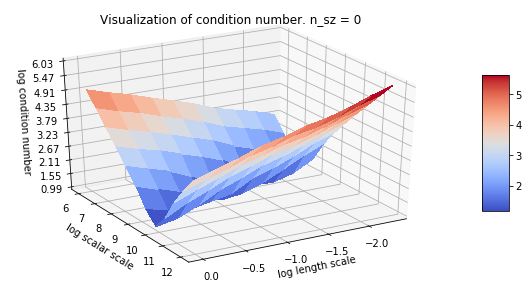

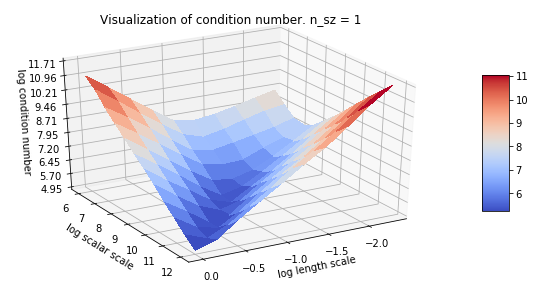

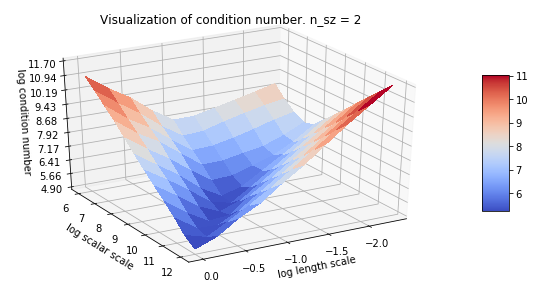

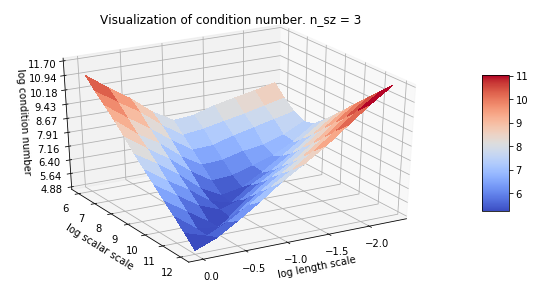

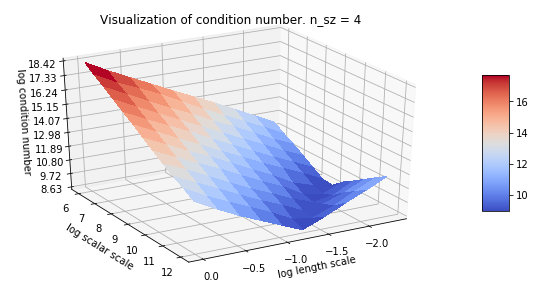

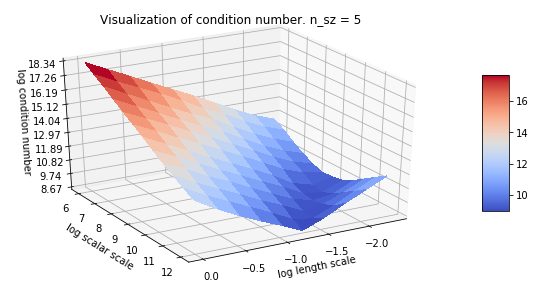

In [9]:
for i in range(6):
    # Filter over number of shearzones.
    mask = np.where(full['n_sz'] == i)[0]
    df = full.loc[mask, :]

    # Map result to log scale
    df['x'] = np.log10(df['ls'])
    df['y'] = np.log10(df['ss'])
    df['z'] = np.log10(df['ratio'])

    # 2D-arrays from DataFrame
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    """
    x, y via meshgrid for vectorized evaluation of
    2 scalar/vector fields over 2-D grids, given
    one-dimensional coordinate arrays x1, x2,..., xn.
    """
    x2, y2 = np.meshgrid(x1, y1)

    # Interpolate unstructured D-dimensional data.
    z2 = scipy.interpolate.griddata(
        (df['x'], df['y']), 
        df['z'], 
        (x2, y2), 
        method='cubic',
    )

    # Ready to plot
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(
        x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False
    )

    ax.set_zlim(df['z'].min(), df['z'].max())

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(f'Visualization of condition number. n_sz = {i}')
    ax.set_xlabel('log length scale')
    ax.set_ylabel('log scalar scale')
    ax.set_zlabel('log condition number')
    
    # Rotate axes
    ax.view_init(30, 60)

    # plt.show()

In [10]:
full.to_csv(
    "~/mastersproject/src/mastersproject/GTS/test/test_scaling/output/data.csv"
)

In [39]:
# Find the optimal scaling coefficient for each group of fractures
full.loc[full.groupby('n_sz')['ratio'].idxmin()]

ls            ss      max_elem     max_A_sum     min_A_sum  \
68   0.080  5.000000e+08  7.246959e+04  2.433867e+05  24708.840597   
155  0.800  1.000000e+12  1.596350e+05  2.651434e+05      2.991827   
284  0.800  5.000000e+11  2.322696e+05  2.387651e+05      2.991827   
438  0.300  5.000000e+10  1.418793e+05  2.200546e+05      2.870429   
643  0.005  1.000000e+09  7.283247e+08  8.546161e+08      2.005668   
740  0.050  1.000000e+12  7.283754e+08  9.291072e+08      2.005668   

            ratio                 shearzone_names  n_sz  
68   9.850188e+00                            None     0  
155  8.862257e+04                          {S1_1}     1  
284  7.980578e+04                    {S1_2, S1_1}     2  
438  7.666261e+04              {S1_2, S1_3, S1_1}     3  
643  4.261004e+08        {S1_2, S1_3, S1_1, S3_1}     4  
740  4.632408e+08  {S1_2, S1_3, S3_2, S3_1, S1_1}     5

In [41]:
n = 3
_mask_nsml = full.groupby('n_sz')['ratio'].nsmallest(n).index.get_level_values(1)
full.loc[_mask_nsml]

ls            ss      max_elem     max_A_sum     min_A_sum  \
68   0.080  5.000000e+08  7.246959e+04  2.433867e+05  24708.840597   
70   0.080  5.000000e+08  7.246959e+04  2.433867e+05  24708.840597   
20   0.800  5.000000e+09  8.239064e+02  2.681291e+03    246.125500   
155  0.800  1.000000e+12  1.596350e+05  2.651434e+05      2.991827   
154  0.800  5.000000e+11  2.791193e+05  2.957781e+05      2.991827   
178  0.300  5.000000e+10  1.470989e+05  2.519211e+05      2.404752   
284  0.800  5.000000e+11  2.322696e+05  2.387651e+05      2.991827   
318  0.100  1.000000e+09  2.268258e+05  2.331691e+05      2.574950   
285  0.800  1.000000e+12  1.360139e+05  2.255963e+05      2.372970   
438  0.300  5.000000e+10  1.418793e+05  2.200546e+05      2.870429   
448  0.100  1.000000e+09  2.269693e+05  2.333278e+05      2.922369   
415  0.800  1.000000e+12  1.367007e+05  2.266813e+05      2.760432   
643  0.005  1.000000e+09  7.283247e+08  8.546161e+08      2.005668   
610  0.050  1.000000e+12  7.283247e+08  9.640116e+08      2.005668   
632  0.010  1.000000e+10  6.449695e+08  1.040829e+09      2.004534   
740  0.050  1.000000e+12  7.283754e+08  9.291072e+08      2.005668   
739  0.050  5.000000e+11  1.456751e+09  1.463936e+09      2.011336   
761  0.010  5.000000e+09  1.165401e+09  1.526820e+09      2.009069   

            ratio                 shearzone_names  n_sz  
68   9.850188e+00                            None     0  
70   9.850188e+00                            None     0  
20   1.089400e+01                            None     0  
155  8.862257e+04                          {S1_1}     1  
154  9.886204e+04                          {S1_1}     1  
178  1.047597e+05                          {S1_1}     1  
284  7.980578e+04                    {S1_2, S1_1}     2  
318  9.055286e+04                    {S1_2, S1_1}     2  
285  9.506918e+04                    {S1_2, S1_1}     2  
438  7.666261e+04              {S1_2, S1_3, S1_1}     3  
448  7.984200e+04              {S1_2, S1_3, S1_1}     3  
415  8.211806e+04              {S1_2, S1_3, S1_1}     3  
643  4.261004e+08        {S1_2, S1_3, S1_1, S3_1}     4  
610  4.806437e+08        {S1_2, S1_3, S1_1, S3_1}     4  
632  5.192372e+08        {S1_2, S1_3, S1_1, S3_1}     4  
740  4.632408e+08  {S1_2, S1_3, S3_2, S3_1, S1_1}     5  
739  7.278423e+08  {S1_2, S1_3, S3_2, S3_1, S1_1}     5  
761  7.599642e+08  {S1_2, S1_3, S3_2, S3_1, S1_1}     5